# FeatureMAP on synthetic data with linear model.

In [35]:
import featuremap

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Download the synthetic data by BEELINE model.

In [36]:
# !curl -o BEELINE-data.zip https://zenodo.org/records/3701939/files/BEELINE-data.zip?download=1
# !unzip BEELINE-data.zip

Read the expression data and pseudotime.

In [37]:
import pandas as pd
# Datasets following Linear model 
data = pd.read_csv('./BEELINE-data/inputs/Synthetic/dyn-LI/dyn-LI-5000-1/ExpressionData.csv', index_col=0).T
data_pseudotime = pd.read_csv('./BEELINE-data/inputs/Synthetic/dyn-LI/dyn-LI-5000-1/Pseudotime.csv', index_col=0)
# replace Nan with 0
data_pseudotime.fillna(0, inplace=True)
# sum PseudoTime1 and PseudoTime2 
data_pseudotime = data_pseudotime.sum(axis=1)



<Axes: >

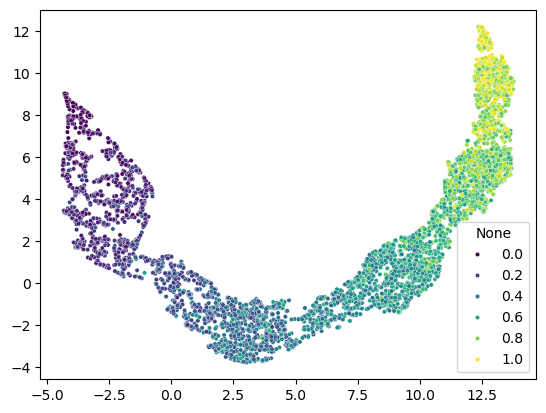

In [38]:
import umap
emb_umap = umap.UMAP().fit_transform(data)
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=emb_umap[:, 0], y=emb_umap[:, 1],hue=data_pseudotime, palette='viridis', s=10)

FeatureMAP expression embedding.

In [39]:
from featuremap import featuremap_
import importlib
importlib.reload(featuremap_)

emb_svd, vh = featuremap_._preprocess_data(data)

data = emb_svd

emb_featuremap = featuremap_.FeatureMAP(
                    min_dist=0.1,
                    random_state=42,
                    n_epochs=400,
                    output_variation=False,
                    verbose=True,
                    ).fit(data)

SVD decomposition time is 3.790855407714844e-05
FeatureMAP(min_dist=0.1, n_epochs=400, random_state=42, verbose=True)
Fri Jun  7 17:18:19 2024 Construct fuzzy simplicial set
Fri Jun  7 17:18:19 2024 Finding Nearest Neighbors
Fri Jun  7 17:18:19 2024 Building RP forest with 9 trees
Fri Jun  7 17:18:19 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Fri Jun  7 17:18:19 2024 Finished Nearest Neighbor Search
Fri Jun  7 17:18:20 2024 Construct embedding
Fri Jun  7 17:18:20 2024 Computing tangent space
Fri Jun  7 17:18:21 2024 Local SVD time is 1.465291976928711
Fri Jun  7 17:18:23 2024 Computing diameter time is 1.6009941101074219
Fri Jun  7 17:18:23 2024 Average over 19 times
Fri Jun  7 17:18:24 2024 Average time is 1.425853967666626
Fri Jun  7 17:18:24 2024 Tangent_space_approximation time is 4.564564228057861
Fri Jun  7 17:18:24 2024 Tangent space embedding


/Users/uqyyao4/opt/anaconda3/envs/featmap/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning:

nopython is set for njit and is ignored



Fri Jun  7 17:18:41 2024 Tangent_space_embedding time is 16.408618927001953
Fri Jun  7 17:18:41 2024 Start optimizing layout


Epochs completed: 100%| ██████████ 400/400 [00:30]

Fri Jun  7 17:19:11 2024 Optimize layout time is 30.27785301208496
Fri Jun  7 17:19:11 2024 Finished embedding


In [40]:
from featuremap import features
import importlib
importlib.reload(features)

adata = features.create_adata(X=data, emb_featuremap=emb_featuremap)
adata.obsm['X_svd'] = emb_svd
adata.varm['svd_vh'] = vh.T

mu is not added to adata


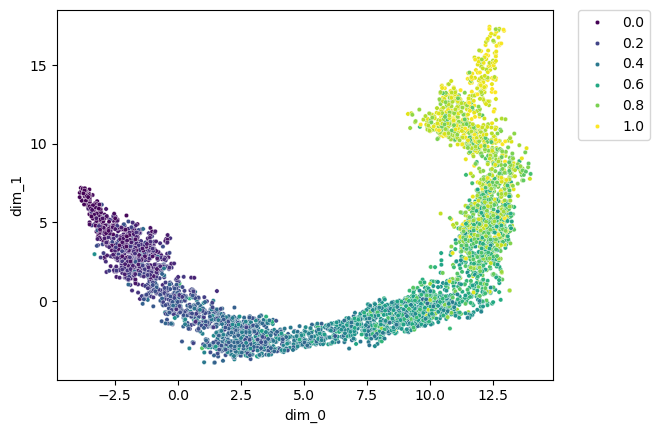

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=100)

embedding_df = pd.DataFrame(adata.obsm["X_featmap"], index=adata.obs_names, columns=['dim_0', 'dim_1'])
embedding_df['pseudotime'] = data_pseudotime
sns.scatterplot(x='dim_0', y='dim_1',hue='pseudotime', data=embedding_df, palette='viridis', s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



FeatureMAP variation embedding.

In [42]:
# from featuremap import featuremap_
# import importlib
# importlib.reload(featuremap_)

emb_featuremap = featuremap.FeatureMAP(
                    random_state=42,
                    output_variation=True,
                    n_epochs=400,
                    ).fit_transform(data)

adata.obsm["X_featmap_v"] = emb_featuremap

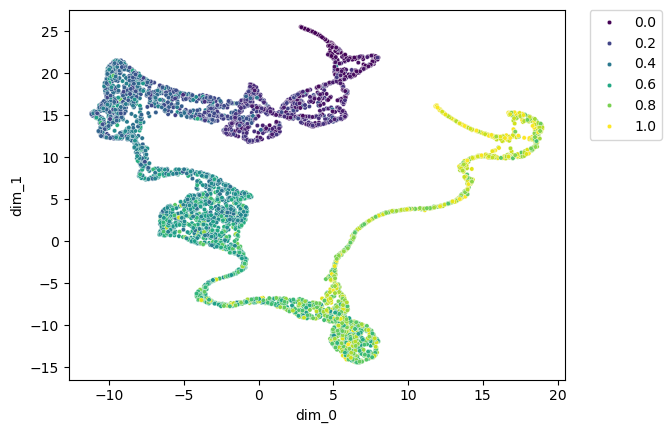

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=100)

embedding_df = pd.DataFrame(adata.obsm["X_featmap_v"], index=data.index, columns=['dim_0', 'dim_1'])
embedding_df['pseudotime'] = data_pseudotime
sns.scatterplot(x='dim_0',y='dim_1', hue='pseudotime', data=embedding_df, palette='viridis', s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [44]:
# from featuremap import featuremap_
# import importlib
# importlib.reload(featuremap_)

emb_featuremap = featuremap.FeatureMAP(
                    n_components=3,
                    random_state=42,
                    output_variation=True,
                    # verbose=True,
                    ).fit_transform(data)

adata.obsm["X_featmap_v_3d"] = emb_featuremap

In [45]:
import plotly   
importlib.reload(plotly)
# importlib.reload(nbformat)
import plotly.express as px
fig_3d = px.scatter_3d(
    emb_featuremap, 
    x=0, y=1, z=2,
    color=data_pseudotime, 
    # labels={'color': 'species'}
    color_continuous_scale='viridis',
    # color_discrete_sequence=[ 'orange', 'blue']
)
fig_3d.update_traces(marker_size=2) # Modify the point size
fig_3d.update_layout(
    autosize=False,
    width=500,
    height=500,
)
fig_3d.show()

# save the plot 
fig_3d.write_html("linear_3d_plot.html")

In [46]:
# from IPython.core.display import display, HTML
# display(HTML('./linear_3d_plot.html'))

<!-- <iframe src="./linear_3d_plot.html" width="800" height="600"></iframe> -->


Plot features.

In [47]:
from featuremap import features
import importlib
importlib.reload(features)

# Starting point index
# Randomly select a starting point by cells with small pseudotime
import numpy as np
start_point_index = np.random.choice(np.where(data_pseudotime < 0.1)[0])
features.pseudotime_mst(adata, 42, start_point_index)


Plotting g1...
Start matrix multiplication
Finish matrix multiplication in 0.0008027553558349609


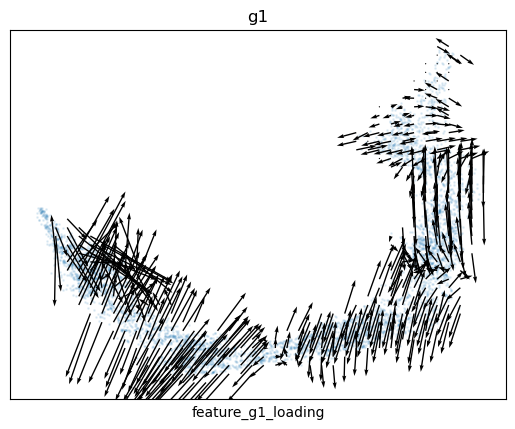

Plotting g2...
Start matrix multiplication
Finish matrix multiplication in 0.0007028579711914062


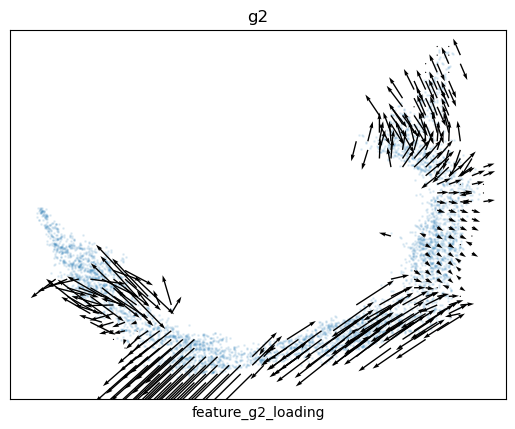

Plotting g3...
Start matrix multiplication
Finish matrix multiplication in 0.0018131732940673828


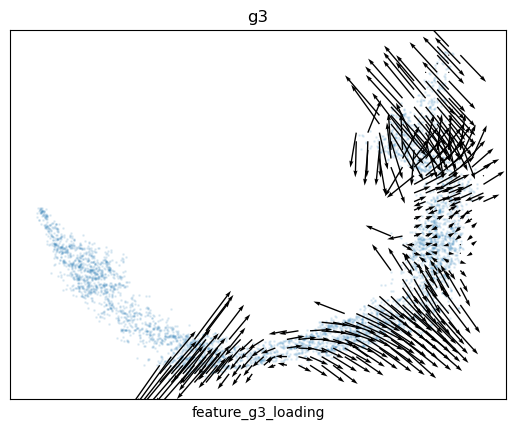

Plotting g4...
Start matrix multiplication
Finish matrix multiplication in 0.0005910396575927734


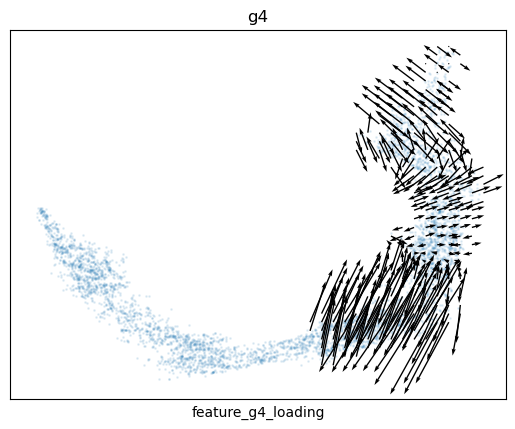

Plotting g5...
Start matrix multiplication
Finish matrix multiplication in 0.0006687641143798828


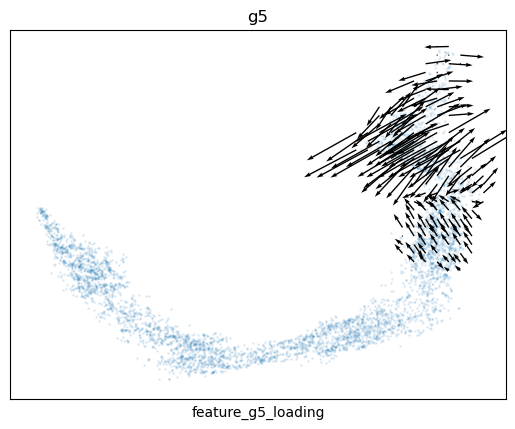

Plotting g6...
Start matrix multiplication
Finish matrix multiplication in 0.0006570816040039062


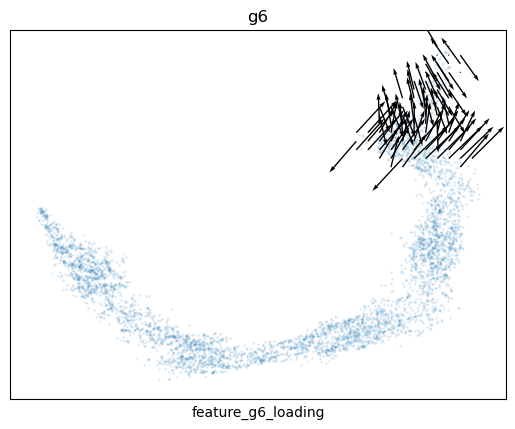

Plotting g7...
Start matrix multiplication
Finish matrix multiplication in 0.0005371570587158203


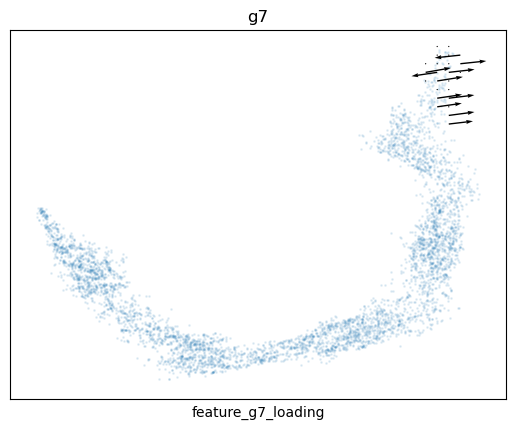

<Figure size 640x480 with 0 Axes>

In [53]:
from featuremap import features
import importlib
importlib.reload(features)

from featuremap.features import feature_projection, plot_one_feature
feature = data.columns

# adata.obs['feat_pseudotime'] = data_pseudotime

for f in feature:
    print(f'Plotting {f}...')
    feature_projection(adata, feature=f)
    plot_one_feature(adata, feature=f, ratio=0.5, density=0.8, embedding='X_featmap', pseudotime='feat_pseudotime', pseudotime_adjusted=False)    


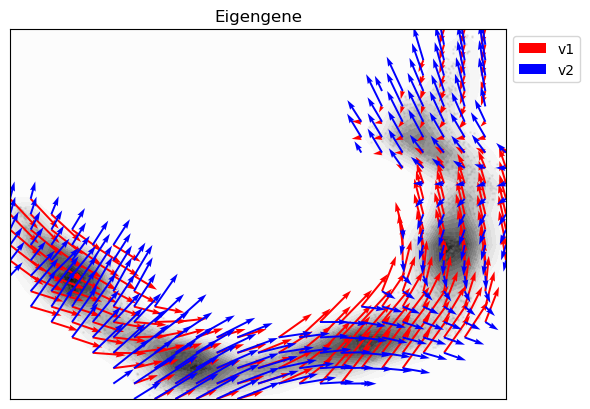

In [54]:
from featuremap import features
import importlib
importlib.reload(features)

features.plot_gauge_both(adata, density=0.5,  embedding='X_featmap',)

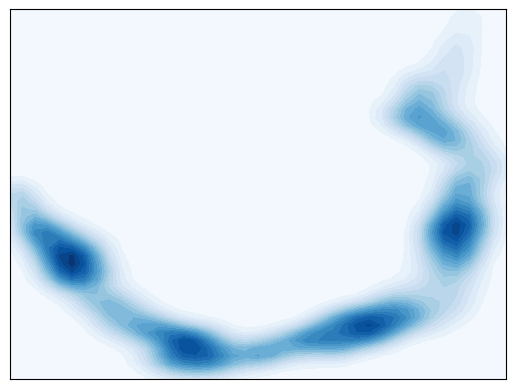

<Figure size 640x480 with 0 Axes>

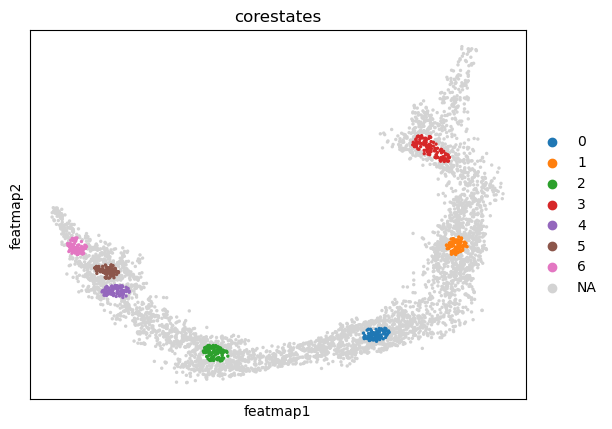

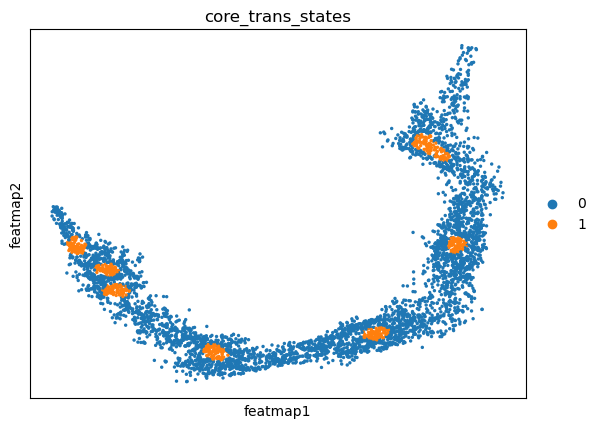

In [55]:
##################################
# Contour plot to show the density
######################################
from featuremap import core_transition_state
import importlib
importlib.reload(core_transition_state)

from featuremap.core_transition_state import plot_density
plot_density(adata)

#%%
#######################################################
# Compute core-states based on clusters
#########################################################

from featuremap.core_transition_state import core_transition_state
core_transition_state(adata)



(Optional) Refine the core states by removing core states 4 and 6, since they are not in the five density peaks.

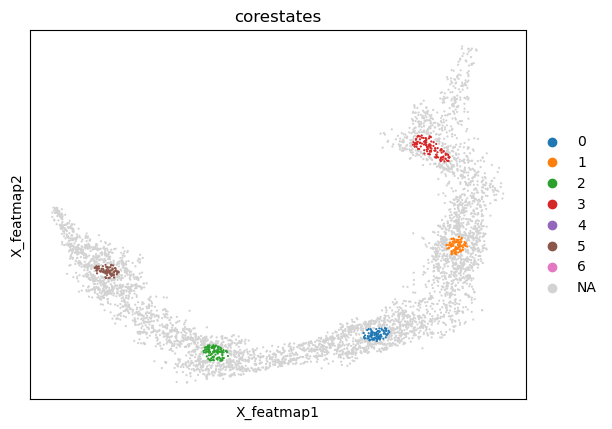

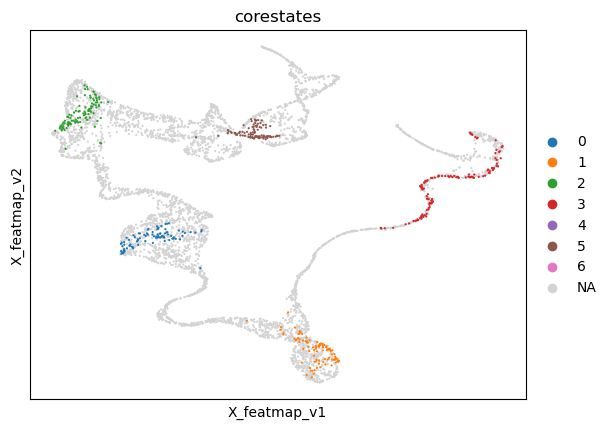

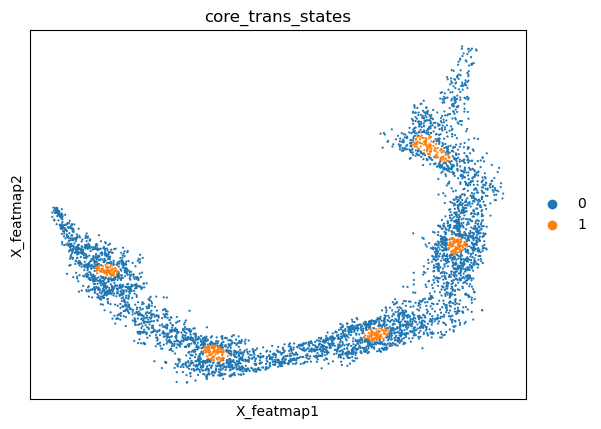

In [57]:
# set core sates '4' and '6' as NaN
adata.obs['corestates'].loc[adata.obs['corestates'] == '4'] = np.nan
adata.obs['corestates'].loc[adata.obs['corestates'] == '6'] = np.nan

import scanpy as sc
sc.pl.embedding(adata, basis='X_featmap', color='corestates', cmap='viridis', s=10)
sc.pl.embedding(adata, basis='X_featmap_v', color='corestates', cmap='viridis', s=10)


# refine the core_trans_states
adata.obs['core_trans_states'] = np.zeros(adata.shape[0]).astype(int).astype(str)
# set all core states to 1
# not nan index 
not_nan_index = adata.obs['corestates'].notna()
not_nan_index = not_nan_index[not_nan_index].index
adata.obs.loc[not_nan_index, 'core_trans_states'] = '1'

# change adata.obs['core_trans_states'] to string



sc.pl.embedding(adata, basis='X_featmap', color='core_trans_states',  s=10)


In [58]:

core_trans_states = adata.obs['core_trans_states'].values
import plotly   
importlib.reload(plotly)
# importlib.reload(nbformat)
import plotly.express as px
fig_3d = px.scatter_3d(
    emb_featuremap, 
    x=0, y=1, z=2,
    color=core_trans_states, 
    # labels={'color': 'species'}
    # color_continuous_scale='viridis',
    color_discrete_sequence=[  'blue', 'orange',]
)
fig_3d.update_traces(marker_size=2) # Modify the point size
fig_3d.update_layout(
    autosize=False,
    width=500,
    height=500,
)
fig_3d.show()

# save the plot
# fig_3d.write_html("3d_plot_core_trans_states.html")